In [1]:
# https://towardsdatascience.com/a-comprehensive-guide-to-downloading-stock-prices-in-python-2cd93ff821d4
# https://pypi.org/project/yfinance/
import sys

!{sys.executable} --version
# !{sys.executable} -m pip install yfinance
# !{sys.executable} -m pip install yahoofinancials

import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
from IPython.display import display

pd.options.mode.chained_assignment = None  # default=‘warn'

%matplotlib inline

Python 3.11.5


In [2]:
!pip freeze

absl-py==2.0.0
aiofiles==23.2.1
altair==5.1.2
annotated-types==0.6.0
ansicon==1.89.0
anyio==3.7.1
appdirs==1.4.4
arch==6.3.0
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci_311/argon2-cffi-bindings_1676424443321/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
astunparse==1.6.3
async-lru @ file:///C:/b/abs_e0hjkvwwb5/croot/async-lru_1699554572212/work
attrs @ file:///C:/b/abs_35n0jusce8/croot/attrs_1695717880170/work
Babel @ file:///C:/ci_311/babel_1676427169844/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backoff==2.2.1
bcrypt==4.0.1
beautifulsoup4 @ file:///C:/b/abs_0agyz1wsr4/croot/beautifulsoup4-split_1681493048687/work
biogeme==3.2.13
biogeme-optimization==0.0.5
bleach @ file:///opt/conda/conda-bld/bleach_1641577558959/work
blessed==1.20.0
blinker==1.6.3
blis==0.7.11
Brotli==1.1.0
bspline==0.1.1
cachetools==5.3.1
catalogue==2.0.10
certifi==2022.12.7
cffi @ file:///C:/ci

# get price history

Close                High                Low               Open  \
                 F         XOM       F         XOM      F         XOM      F   
Date                                                                           
2024-09-05  10.770  113.169998  11.140  115.279999  10.72  113.070000  11.08   
2024-09-06  10.580  112.639999  10.870  114.180000  10.53  111.730003  10.78   
2024-09-09  10.660  115.010002  10.760  116.150002  10.54  112.660004  10.61   
2024-09-10  10.325  110.995003  10.455  115.400002  10.17  110.169998  10.49   

                          Volume            
                   XOM         F       XOM  
Date                                        
2024-09-05  115.070000  50551900  17200800  
2024-09-06  113.589996  47508900  13467700  
2024-09-09  112.870003  39189700  21644200  
2024-09-10  115.099998  46970729  13252762

<Axes: title={'center': 'Ford stock price'}, xlabel='Date'>

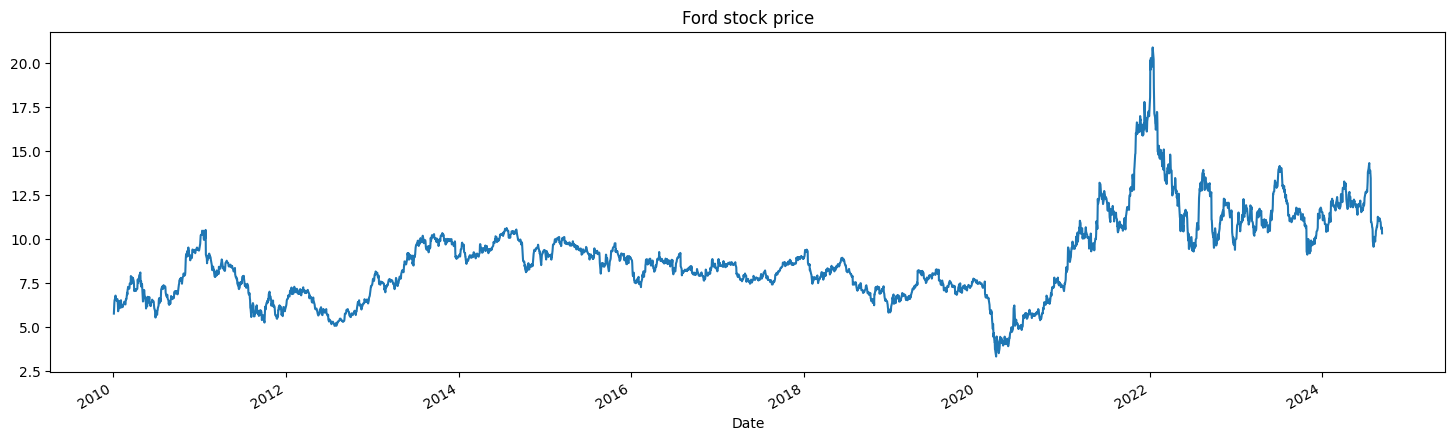

In [3]:
import pickle

prices_df = pickle.load(open("prices.pkl",'rb'))
display(prices_df[-4:])

plt.figure(figsize=(18,5))
prices_df[('Close','F')].plot(title="Ford stock price")

# calculate daily returns

In [4]:
from math import log

prices_f = prices_df[[('Close','F')]].squeeze()   # convert from dataframe to series
returns_f = prices_f.apply(log).diff()[1:]        # compute first order differences in the log prices = daily return
print(type(returns_f))
returns_f

<class 'pandas.core.series.Series'>


Date
2010-01-05    0.064052
2010-01-06    0.036726
2010-01-07    0.025186
2010-01-08    0.002570
2010-01-11    0.035297
                ...   
2024-09-04   -0.002736
2024-09-05   -0.016575
2024-09-06   -0.017799
2024-09-09    0.007533
2024-09-10   -0.031930
Name: (Close, F), Length: 3695, dtype: float64

# Moving average
using https://numpy.org/doc/stable/reference/generated/numpy.convolve.html

### np.convolve(x, y) = $\sum{x_t, y_i}$ 
### if length of x > length of y, then use a sliding window over x of the length of y

### for a moving average for w days of prices, y = vector of values of 1/w

In [5]:
import numpy as np

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

x = np.array([5,3,8,10,2,1,5,1,0,2])

print(moving_average(x, 4))

[6.5  5.75 5.25 4.5  2.25 1.75 2.  ]


In [6]:
np.convolve([1,2,3,2],[0,1,0.5], 'valid')

array([2.5, 4. ])

In [7]:
MA_200 = moving_average(np.array(prices_f),200)
MA_50 = moving_average(np.array(prices_f),50)[-len(MA_200):]

MA = pd.DataFrame([MA_200, MA_50], columns=prices_f.index[-len(MA_200):], index=['200','50']).transpose()
MA

,200,50
Date,,
2010-10-18,6.800044,6.929002
2010-10-19,6.808556,6.932026
2010-10-20,6.816059,6.940089
2010-10-21,6.822891,6.955768
2010-10-22,6.829302,6.974582
...,...,...
2024-09-04,11.626066,11.653865
2024-09-05,11.631794,11.631174
2024-09-06,11.636051,11.604288


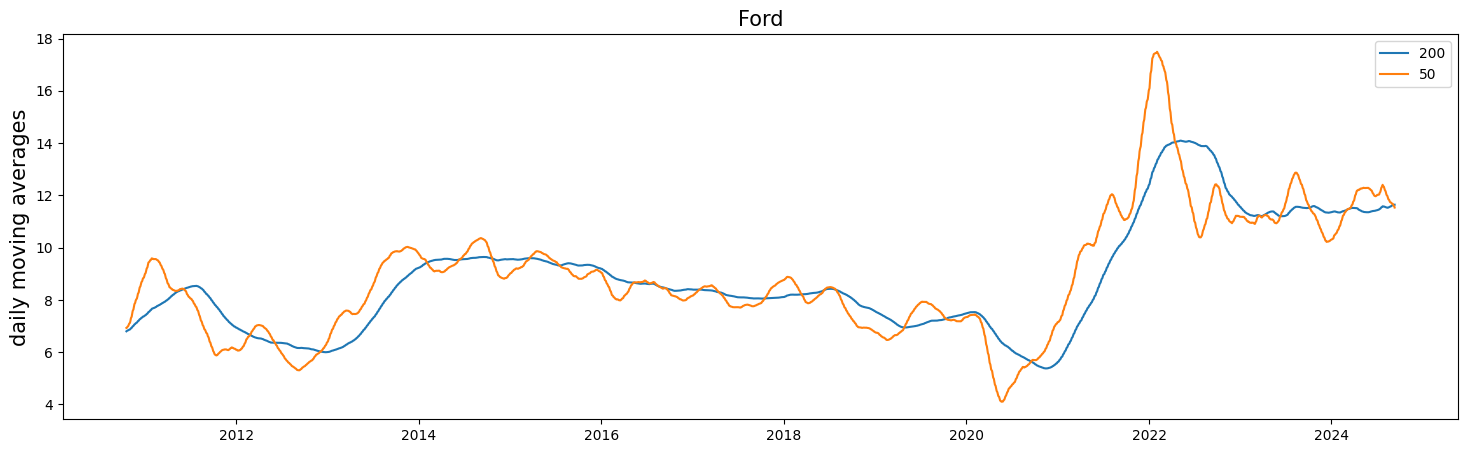

In [8]:
plt.figure(figsize=(18,5))
plt.plot(MA)
plt.legend(MA.columns)
plt.title('Ford', fontsize=15)
plt.ylabel('daily moving averages', fontsize=15)
plt.show()

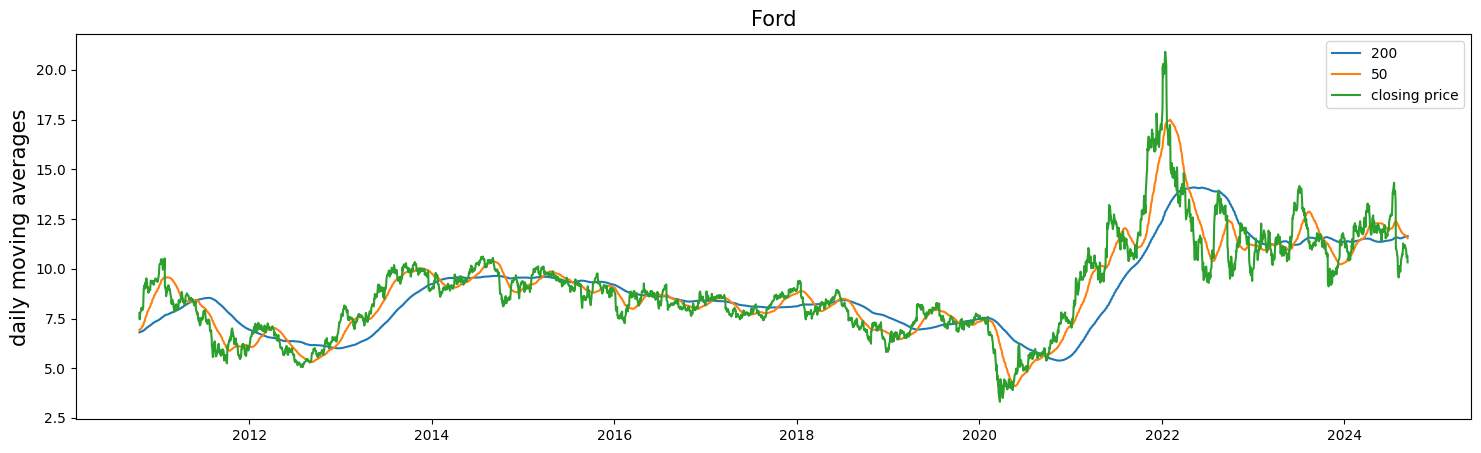

In [9]:
MA['closing price'] = prices_f[-len(MA_200):]
plt.figure(figsize=(18,5))
plt.plot(MA)
plt.legend(MA.columns)
plt.title('Ford', fontsize=15)
plt.ylabel('daily moving averages', fontsize=15)
plt.show()

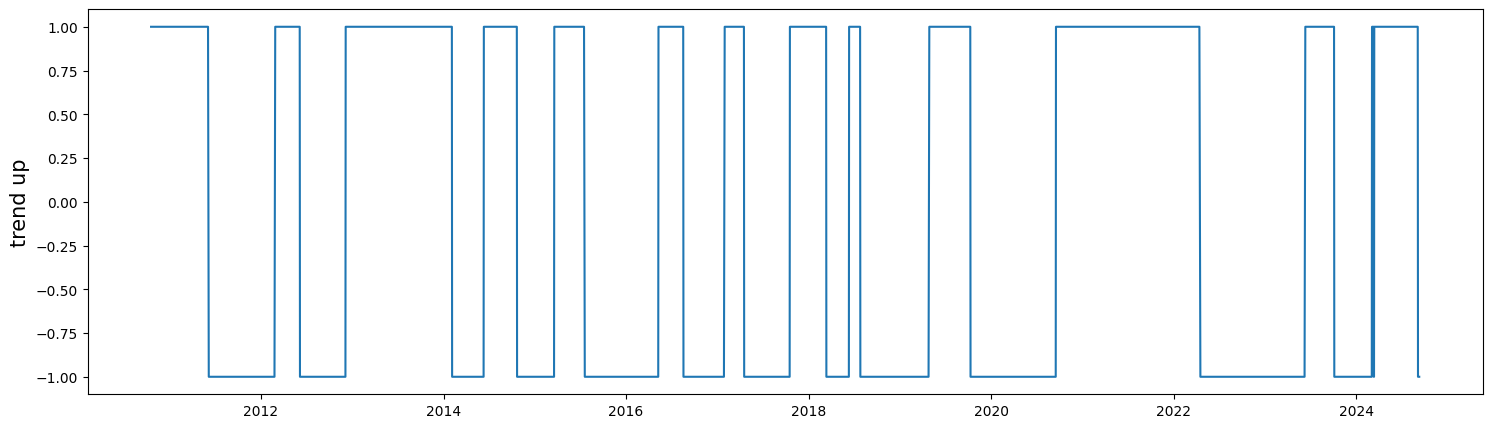

In [10]:
plt.figure(figsize=(18,5))
MA['trend up'] = 2*(MA_50 > MA_200) - 1
plt.plot(MA['trend up'])
plt.ylabel('trend up', fontsize=15)
plt.show()

In [11]:
MA1 = MA.copy()
MA1['long position'] = MA['trend up'].shift(1)
MA1['price'] = prices_f[-MA1.shape[0]:]
MA1['returns'] = returns_f[-MA1.shape[0]:]
display(MA1[:5])
display(MA1[530:540])
display(MA1[-5:])

,200,50,closing price,trend up,long position,price,returns
Date,,,,,,,
2010-10-18,6.800044,6.929002,7.772186,1,NaN,7.772186,0.005781
2010-10-19,6.808556,6.932026,7.458608,1,1.0,7.458608,-0.041183
2010-10-20,6.816059,6.940089,7.637794,1,1.0,7.637794,0.023740
2010-10-21,6.822891,6.955768,7.732987,1,1.0,7.732987,0.012386
2010-10-22,6.829302,6.974582,7.811380,1,1.0,7.811380,0.010086


,200,50,closing price,trend up,long position,price,returns
Date,,,,,,,
2012-11-26,6.044635,5.960171,6.337271,-1,-1.0,6.337271,0.000901
2012-11-27,6.040625,5.969411,6.331567,-1,-1.0,6.331567,-0.000901
2012-11-28,6.037744,5.978205,6.417129,-1,-1.0,6.417129,0.013423
2012-11-29,6.035381,5.991782,6.576843,-1,-1.0,6.576843,0.024584
2012-11-30,6.032959,6.004106,6.531213,-1,-1.0,6.531213,-0.006962
2012-12-03,6.030704,6.014044,6.508395,-1,-1.0,6.508395,-0.003500
2012-12-04,6.027152,6.024544,6.451354,-1,-1.0,6.451354,-0.008803
2012-12-05,6.023571,6.035498,6.451354,1,-1.0,6.451354,0.000000
2012-12-06,6.020409,6.046562,6.411424,1,1.0,6.411424,-0.006209


,200,50,closing price,trend up,long position,price,returns
Date,,,,,,,
2024-09-04,11.626066,11.653865,10.950,1,1.0,10.950,-0.002736
2024-09-05,11.631794,11.631174,10.770,-1,1.0,10.770,-0.016575
2024-09-06,11.636051,11.604288,10.580,-1,-1.0,10.580,-0.017799
2024-09-09,11.640376,11.576640,10.660,-1,-1.0,10.660,0.007533
2024-09-10,11.643737,11.536187,10.325,-1,-1.0,10.325,-0.031930


In [12]:
MA2 = MA1[1:]
MA2['buy and hold'] = MA2['returns'].cumsum()
MA2['trend returns'] = [r if t else -r for r,t in zip(MA2['returns'],MA2['long position'])]
MA2['trend strategy'] = MA2['trend returns'].cumsum()
MA2


,200,50,closing price,trend up,long position,price,returns,buy and hold,trend returns,trend strategy
Date,,,,,,,,,,
2010-10-19,6.808556,6.932026,7.458608,1,1.0,7.458608,-0.041183,-0.041183,-0.041183,-0.041183
2010-10-20,6.816059,6.940089,7.637794,1,1.0,7.637794,0.023740,-0.017443,0.023740,-0.017443
2010-10-21,6.822891,6.955768,7.732987,1,1.0,7.732987,0.012386,-0.005056,0.012386,-0.005056
2010-10-22,6.829302,6.974582,7.811380,1,1.0,7.811380,0.010086,0.005030,0.010086,0.005030
2010-10-25,6.836189,6.996981,7.923374,1,1.0,7.923374,0.014235,0.019266,0.014235,0.019266
...,...,...,...,...,...,...,...,...,...,...
2024-09-04,11.626066,11.653865,10.950000,1,1.0,10.950000,-0.002736,0.342788,-0.002736,0.342788
2024-09-05,11.631794,11.631174,10.770000,-1,1.0,10.770000,-0.016575,0.326213,-0.016575,0.326213
2024-09-06,11.636051,11.604288,10.580000,-1,-1.0,10.580000,-0.017799,0.308414,-0.017799,0.308414


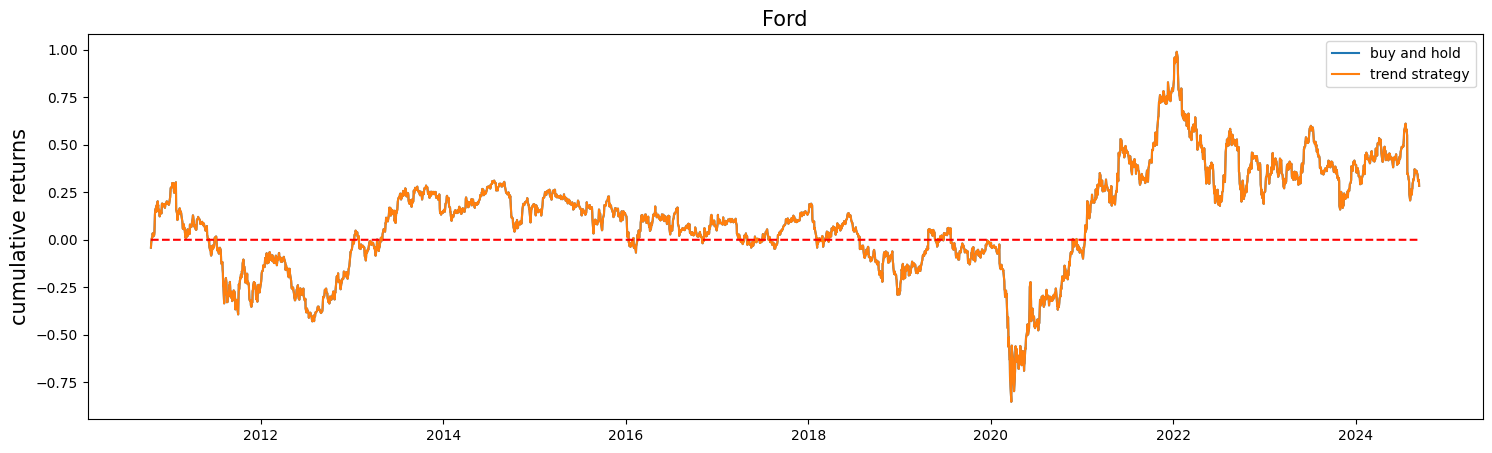

In [13]:
plt.figure(figsize=(18,5))
plt.plot(MA2[['buy and hold', 'trend strategy']])
plt.plot(pd.DataFrame([0.0] * MA2.shape[0], index=MA2.index), '--', color='red')
plt.legend(['buy and hold', 'trend strategy'])
plt.title('Ford', fontsize=15)
plt.ylabel('cumulative returns', fontsize=15)
plt.show()

In [14]:
long_profit = MA2[[p == 1.0 for p in MA2['long position']]]['returns'].sum()
short_profit = -MA2[[p == -1.0 for p in MA2['long position']]]['returns'].sum()
long_profit, short_profit, MA2['returns'].sum()

(-0.22348282148594079, -0.507499503983591, 0.2840166824976502)

In [15]:
MA2[['returns','trend returns']].describe()

,returns,trend returns
count,3496.000000,3496.000000
mean,0.000081,0.000081
std,0.021404,0.021404
min,-0.202868,-0.202868
25%,-0.009977,-0.009977
50%,0.000000,0.000000
75%,0.010456,0.010456
max,0.210596,0.210596
